---
# Model S - From Scratch, Data Augmentation, Adam Optimizer
- **32 x 32** x 3 Image size.  
- **64** Batch size.  
- Horizontal Flip, Contrast and Brightness **Data augmentation**.  
- **Adaptive Moment Estimation (Adam) optimizer**.  
- **0.001** Initial Learning rate.  
- **3 x 3** Convolutional kernel size.  
- **5 x 5 x 256** Tensor before flatten.  
- **30** Epochs.  

---
#### Imports and Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import callbacks, layers, optimizers, models
from keras import regularizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay ,accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

TensorFlow version: 2.15.0


---
#### Group Datasets

In [2]:
train_dirs = ['../data/train1', '../data/train3', '../data/train4', '../data/train5']
validation_dir = '../data/train2'
test_dir = '../data/test'

- ((2221985 + 2221986) % 5) + 1 = 2  
- **Validation set: train2**.  

---
#### Create Datasets

In [3]:
IMG_SIZE = 32
BATCH_SIZE = 64
NUM_CLASSES = 10

train_datasets = [image_dataset_from_directory(directory, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE) for directory in train_dirs]

train_dataset = train_datasets[0]
for dataset in train_datasets[1:]:
    train_dataset = train_dataset.concatenate(dataset)

train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = image_dataset_from_directory(validation_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

class_names = train_datasets[0].class_names

for data_batch, labels_batch in train_dataset.take(1):
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)

Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
data batch shape: (64, 32, 32, 3)
labels batch shape: (64,)


- We define the image size of 32 x 32 x 3 and batch size of 64 and create an array with the label's names.  
- We create the train dataset by concatenating them, we **shuffle** the samples before each epoch and **prefetch** them to memory.  
- We do the same for the validation and test dataset except shuffling which is unnecessary.

---
#### Data Augmentation

In [4]:
data_augmentation = keras.Sequential(
    [
        # keras.layers.RandomCrop(height=16, width=16), # This layer is commented out because it is not compatible with the current model architecture.
        keras.layers.RandomFlip("horizontal"),
        # keras.layers.RandomTranslation(0.1, 0.1), # This layer is commented out because it didn't improve the model performance.
        # keras.layers.RandomRotation(0.1), # This layer is commented out because it didn't improve the model performance.
        # keras.layers.RandomZoom(0.1), # This layer is commented out because it didn't improve the model performance.
        # keras.layers.RandomContrast(0.05), # This layer is commented out because it didn't improve the model performance.
        # keras.layers.RandomBrightness(0.05), # This layer is commented out because it didn't improve the model performance.
    ]
)

- We define a data augmentation pipeline to apply to the images.  
- **The pipeline:**  
    - Applies horizontal flipping to a random 50% of the images that go through it.
    - Randomly adjusts the contrast of the input images by 10%.  
    - Randomly adjusts the brightness of the input images by 10%.  

- **The following techniques were tested but the model didn't perform well:**
    - RandomCrop: Randomly crops the images along the width and height down to 16 x 16.
    - Randomly translates the input images along the width and height by 10%.  
    - Randomly rotates the input images by 10%.
    - Randomly zooms the input images by 10%. 
- **We also didn't find any custom augmentation techniques that improved the model performance**.

---
#### Model Architecture

In [5]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, kernel_regularizer=regularizers.L1L2(0.00001, 0.0001), activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=64, kernel_size=3, kernel_regularizer=regularizers.L1L2(0.00001, 0.0001), activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, kernel_regularizer=regularizers.L1L2(0.00001, 0.0001), activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=256, kernel_size=3, kernel_regularizer=regularizers.L1L2(0.00001, 0.0001), activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.L1L2(0.0001, 0.001))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", kernel_regularizer=regularizers.L1L2(0.0001, 0.001))(x)
model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                             

- **We decided to keep the previous architecture and add data augmentation to the model**.
- Input size of 32 x 32 x 3 (RGB).  
- Data augmentation (Horizontal Flip, Contrast (+-10%), Brightness (+-10%)).  
- Normalize each pixel value in the [0, 1] interval.  
- Two convolutional layers of 32 and 64 kernels each.
- Max pooling with size 2 after the second convolution results in a 14 x 14 x 32 tensor.  
- Two convolutional layers of 128 and 256 kernels each.
- Max pooling with size 2 after the fourth convolution results in a 5 x 5 x 128 tensor.  
- 3 x 3 convolutional kernel size.  
- Batch Normalization after each convolutional layer to help stabilize and accelerate learning process.  
- L1 regularization 0.00001 and L2 regularization 0.0001 on the convolutional layers.  
- Flatten the tensor to a 6400 x 1 tensor.  
- A 512 and 10 dense output layer, one for each category. 
- L1 regularization 0.0001 and L2 regularization 0.001 on the 512 and 10 dense layer.  
- Dropout of 0.5 before the 128 dense layer and after the 512 dense layer.
- ReLU activation function on the convolutional and dense layers.  
- Softmax activation function on the output layer from multiclass classification.   

---
#### Model Compilation

In [6]:
initial_learning_rate = 0.01
optimizer = optimizers.SGD(learning_rate=initial_learning_rate, momentum=0.9, nesterov=True)
loss_function = keras.losses.SparseCategoricalCrossentropy()

lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
save_best_model = callbacks.ModelCheckpoint(filepath='../models/03_model_s_data_augm_sgd.keras', save_best_only=True, monitor='val_loss', verbose=1)

callbacks = [lr_scheduler, early_stopping, save_best_model]

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

- **Adam** as the optimizer for this model with an initial learning rate of **0.001**.  
- Sparse categorical cross entropy as the loss function.  
- Learning rate scheduler to lower the learning rate by 0.1 on validation loss plateau (patience of 2).  
- Early train stopping based on validation loss improvement (stops when validation loss doesn't improve for 4 straight epochs (patience of 4)).  
- Checkpoints to save the best model between each epoch based on validation loss. 

---
#### Model Training
- Training the model during 30 epochs.  

In [7]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=40,
                    callbacks=callbacks)

Epoch 1/40
628/628 [==============================] - ETA: 0s - loss: 6.3004 - accuracy: 0.4102
Epoch 1: val_loss improved from inf to 4.78598, saving model to ../models/03_model_s_data_augm_sgd.keras
628/628 [==============================] - 79s 124ms/step - loss: 6.3004 - accuracy: 0.4102 - val_loss: 4.7860 - val_accuracy: 0.4759 - lr: 0.0100
Epoch 2/40
628/628 [==============================] - ETA: 0s - loss: 3.7642 - accuracy: 0.5474
Epoch 2: val_loss improved from 4.78598 to 2.98957, saving model to ../models/03_model_s_data_augm_sgd.keras
628/628 [==============================] - 74s 118ms/step - loss: 3.7642 - accuracy: 0.5474 - val_loss: 2.9896 - val_accuracy: 0.5688 - lr: 0.0100
Epoch 3/40
628/628 [==============================] - ETA: 0s - loss: 2.4198 - accuracy: 0.6215
Epoch 3: val_loss improved from 2.98957 to 2.17063, saving model to ../models/03_model_s_data_augm_sgd.keras
628/628 [==============================] - 74s 116ms/step - loss: 2.4198 - accuracy: 0.6215 - v

---
#### Save Model History

In [8]:
with open("../history/03_model_s_data_augm_sgd.pkl", "wb") as file:
    pickle.dump(history.history, file)

---
#### Model Evaluation

In [9]:
val_loss, val_acc = model.evaluate(validation_dataset)
print(f'Model Validation Loss: {val_loss:.2f}')
print(f'Model Validation Accuracy: {val_acc:.2%}')

157/157 [==============================] - 3s 22ms/step - loss: 0.8748 - accuracy: 0.8383
Model Validation Loss: 0.87
Model Validation Accuracy: 83.83%


---
#### Model Training Visualization

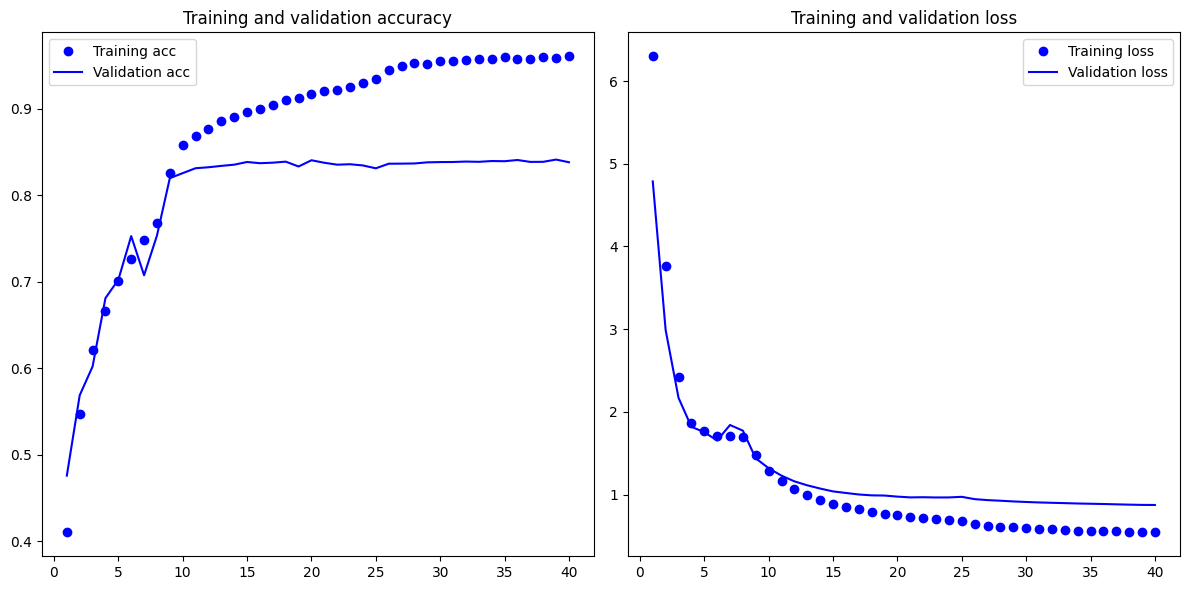

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()

- Analyzing the training and validation accuracy and loss over the epochs:
    - We see that the model begins slightly overfitting after the **15th** epoch. The validation accuracy stops improving significantly while the training accuracy keeps improving.  
    - The validation loss stops improving significantly after the **15th** epoch while the training loss keeps improving. 
    - The best model, based on validation loss, is saved on the **20th** epoch. 

---
#### Model Testing

In [11]:
test_labels = []
test_predictions = []
test_probabilities = []

for images, labels in test_dataset:
    test_labels.extend(labels.numpy())
    predictions = model.predict(images)
    test_predictions.extend(np.argmax(predictions, axis=-1))
    test_probabilities.extend(predictions)

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)
test_probabilities = np.array(test_probabilities)

1/1 [==============================] - 0s 74ms/step


---
#### Confusion Matrix

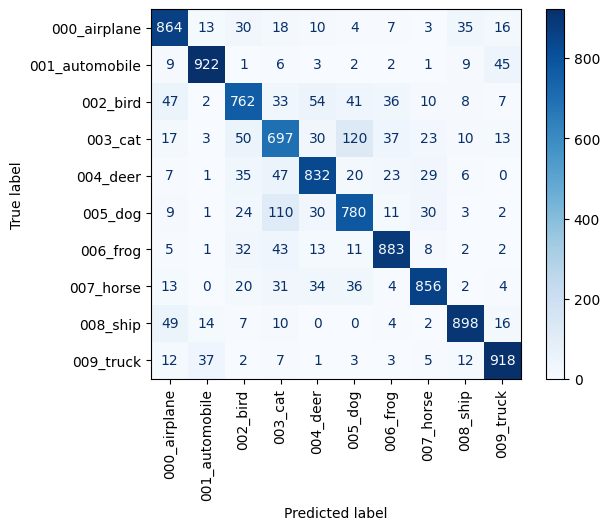

In [12]:
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

- Looking at the confusion matrix, we see that the model has some trouble distinguishing between some categories.  
- The model has a hard time distinguishing between the categories 003_cat and 005_dog.  
- The model also has a hard time distinguishing the class 002_bird.
- The model also has a hard time distinguishing between some other categories but the error is not as significant.  
- The model has an acceptable performance on the categories 000_airplane, 001_automobile, 006_frog, 007_horse, 008_ship and 009_truck.

---
#### ROC Curve Analysis

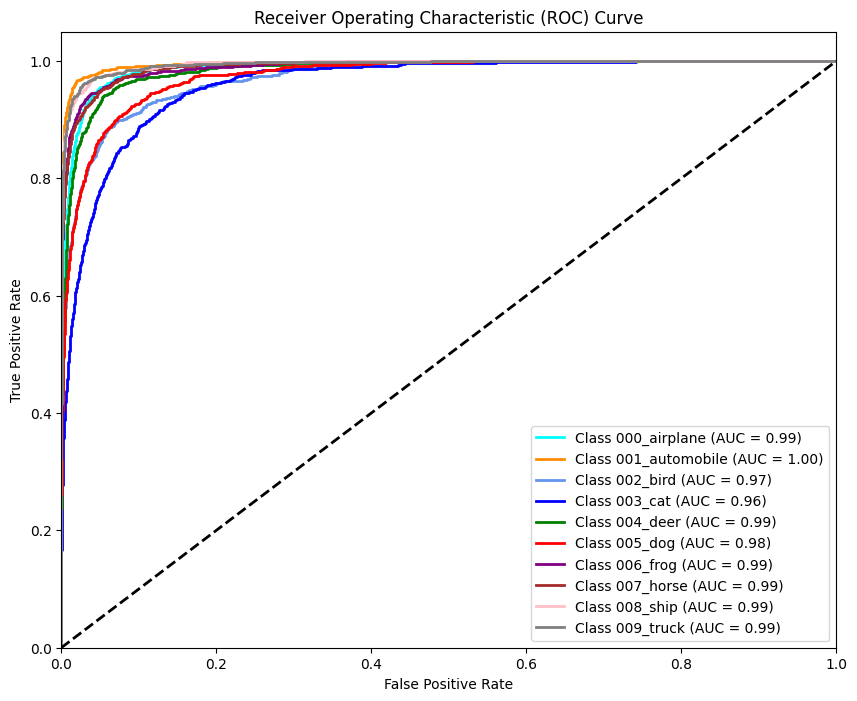

In [13]:
test_labels_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))

false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(test_labels_bin[:, i], test_probabilities[:, i])
    roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'grey'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(false_positive_rate[i], true_positive_rate[i], color=color, lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

- **A perfect AUC of 1.0 would mean that the model classifies all true positives and true negatives correctly**.
- We see that the model has a good performance on the ROC curve for most categories.  
- The categories 003_cat, 002_bird and 005_dog have the worst AUC (Area Under Curve) performance.

---
#### Performance Metrics
- **Accuracy** is the proportion of correctly predicted instances out of the total instances.  
- **Precision** is the ratio of true positive predictions to the total predicted positives. Macro precision calculates this for each class independently and then averages them.  
- **Weighted precision** calculates the precision for each class, then averages them, weighted by the number of true instances for each class.  
- **Recall** is the ratio of true positive predictions to the total actual positives. Macro recall calculates this for each class independently and then averages them.  
- **Weighted recall** calculates the recall for each class, then averages them, weighted by the number of true instances for each class.  
- The **F1-score** is the harmonic mean of precision and recall. Macro F1-score calculates this for each class independently and then averages them.  
- **Weighted F1-score** calculates the F1-score for each class, then averages them, weighted by the number of true instances for each class.

In [14]:
acc = accuracy_score(y_true =  test_labels, y_pred = test_predictions)
print(f'Accuracy : {np.round(acc*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Precision - Macro: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Recall - Macro: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'F1-score - Macro: {np.round(f1*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Precision - Weighted: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Recall - Weighted: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'F1-score - Weighted: {np.round(f1*100,2)}%')

Accuracy : 84.12%
Precision - Macro: 84.13%
Recall - Macro: 84.12%
F1-score - Macro: 84.12%
Precision - Weighted: 84.13%
Recall - Weighted: 84.12%
F1-score - Weighted: 84.12%


- **Since the dataset is balanced, the MACRO average is a good metric to evaluate the model.**

# Conclusion
- We have trained a model with **Data Augmentation Techniques (Horizontal Flip, Contrast and Brightness)**, using the **Sparse Categorical Cross-Entropy** loss function and the **Adam optimizer**.  
- We experimented with various architectures, but decided to keep the same architecture in this notebook, to see the results of data augmentation.
    - Different learning rates were tested; we settled for the Reduce Learning Rate on Plateau callback with a starting value of 0.001. 
    - Various batch sizes were explored; 64 was the most effective. 
    - Multiple optimizers were evaluated; we settled for Adam for this model.
    - Several regularization values were tried; this combination provided the best results.
    - Different dropout rates were assessed; this rate provided the best results.
    - Various epoch counts were tested; 30 epochs were optimal.
    - Different kernel sizes were considered; this size was the most effective.
    - Various numbers of kernels were tested; this configuration was a combination of simple and effective.
    - Different numbers of MaxPooling layers were evaluated; this number was the most effective.
    - We opted to add Batch Normalization after each convolutional layer.
    - We used L1 and L2 regularization on both convolutional and dense layers.
    - Dropout was applied to the dense layers.
- The model showed some difficulty distinguishing between certain categories, particularly cats and dogs.
- Overfitting was observed after **15 epochs**, but the best model was saved at the **20th epoch**.
- We evaluated the model using a confusion matrix to analyze its performance on each category.
- We evaluated the model using ROC curves for a deeper performance analysis.
- **The model achieved an accuracy of 81.83% on the test set**.
- Performance on the test set was good, with:
    - Macro F1-score: 81.78%
    - Weighted F1-score: 81.78%
    - Macro precision: 81.77%
    - Weighted precision: 81.77%
    - Macro recall: 81.83%
    - Weighted recall: 81.83%

### Future Work
- In the next phase, we will:
    - For the next notebook, we will try feature extraction with a pre-trained model, The VGG16.
    - Experiment with different architectures for the classifier.
    - Compile the full model and test it.